# Lab session #1 - ST7-83

The goal of this lab session is to manipulate QisKit, and, along the way, double-check what has been said in class.

# Some imports

In [ ]:
! python -m pip install matplotlib
! python -m pip install qiskit qiskit-aer

In [1]:
from qiskit import *
from qiskit_aer import AerSimulator, StatevectorSimulator
import numpy as np
from math import pi

# Some helper functions

We are going to use two simulators:
* `StateVectorSimulator`: for pure unitary circuits, get the output state when quantum registers are initialized with $|00...00\rangle$.
* `AerSimulator`: for circuits with measurements, perform several runs and collect (classical) results.

These are producing sophisticated outputs: the next functions are meant to output them in a readable way.
  

In [2]:
def processOneState(st): # Longueur = puissance de 2
        s = list(st)
        if len(s) == 2:
            return {'0' : s[0], '1' : s[1]}
        else:
            a0 = processOneState(s[:len(s)//2])
            a1 = processOneState(s[len(s)//2:])
            r = {}
            for k in a0:
                r['0' + k] = a0[k]
            for k in a1:
                r['1' + k] = a1[k]
            return r

def printOneState(d): # get a dict as per processStates output
    for k in d:
        im = d[k].imag
        re = d[k].real
        if abs(im) >= 0.001 or abs(re) >= 0.001:
            print("% .3f + % .3fj |%s>" % (re,im,k))

def printFinalRes(result):
    printOneState(processOneState(list(np.asarray(result))))


def runStateVector(qc):
    simulator = StatevectorSimulator()
    job = simulator.run(qc.decompose(reps=6), memory=True)
    job_result = job.result()
    result = job_result.results[0].to_dict()['data']['statevector']
    printFinalRes(result)

def runSample(qc,howmany):
    simulator = AerSimulator()
    job = simulator.run(qc.decompose(reps=6), shots=howmany)
    res = dict(job.result().get_counts(qc))
    return res

# Examples

In this section, we show how to build circuits, print them, and how to use the functions. A summary of native operations can be found here:
https://docs.quantum.ibm.com/guides/construct-circuits.

All the already defined gates are here: https://docs.quantum.ibm.com/api/qiskit/circuit_library

In [4]:
def exampleDraw():
    q = QuantumRegister(2, name="x")    # Allocating 2 qubits
    c = ClassicalRegister(2, name="y")  # Allocating 2 bits

    # We build a quantum circuit with both registers.
    # By default, everything is initialized to 0 and to |0>
    qc = QuantumCircuit(q,c)

    qc.h(q[0])        # Applying Hadamard on qubit 0:
    qc.x(q[0])        # Applying X on qubit 0:
    qc.z(q[0])        # Applying z on qubit 0:
    qc.cx(q[0],q[1])  # Applying CNOT on qubits 0 and 1:
    qc.measure(q, c)  # Mesure of all of register q, storing results in c.
                      # This is still part of the circuit !
    print(qc)         # print the circuit in ASCII form

exampleDraw()

     ┌───┐┌───┐┌───┐     ┌─┐   
x_0: ┤ H ├┤ X ├┤ Z ├──■──┤M├───
     └───┘└───┘└───┘┌─┴─┐└╥┘┌─┐
x_1: ───────────────┤ X ├─╫─┤M├
                    └───┘ ║ └╥┘
y: 2/═════════════════════╩══╩═
                          0  1 


Getting the output state vector after running a circuit 

In [3]:
def exampleStateVector():
    q1 = QuantumRegister(3, name="q1")
    q2 = QuantumRegister(1, name="q2")
    qc = QuantumCircuit(q1,q2)
    
    qc.x(q1[0])
    qc.x(q1[1])
    qc.h(q2[0])
    qc.cx(q2[0],q1[2])

    runStateVector(qc)

exampleStateVector()

 0.707 +  0.000j |0011>
 0.707 +  0.000j |1111>


Getting a probability distribution

In [11]:
def exampleSample():
    q = QuantumRegister(3, name="q1")
    c = ClassicalRegister(3)
    qc = QuantumCircuit(q,c)
    
    qc.x(q[0])
    qc.h(q[1])
    qc.cx(q[1],q[2])
    qc.measure(q,c)

    return runSample(qc,1000)

print(exampleSample())

{'111': 480, '001': 520}


### Note how the bits are written in the inverse order with respect to what we saw in class!

# Exercices

## Exercice 1

1. Build a circuit producing the 4-qubit state 

$$\frac1{\sqrt2}(|0000\rangle - |1111\rangle)$$

2. Make it parametric: we want to be able to make an `n`-qubit state of that form

3. Try it for various `n` and make sure it works

4. output a sample (therefore: the result of a series of measures): can you see the $-1$ coefficient in front of the $|111..1\rangle$? Can you say why?

In [ ]:
def create_bell_state(n):
    """
    Create a quantum circuit that generates the n-qubit Bell-like state:
    (|000...000⟩ - |111...111⟩) / sqrt(2)
    """
    qr = QuantumRegister(n, name="q")  # Quantum Register with n qubits
    cr = ClassicalRegister(n, name="c")  # Classical Register with n bits
    qc = QuantumCircuit(qr, cr)

    # Apply Hadamard gate to the first qubit
    qc.h(qr[0])

    # Apply CNOT gates from the first qubit to all others
    for i in range(1, n):
        qc.cx(qr[0], qr[i])

    # Apply a Z gate to introduce the negative sign
    qc.z(qr[0])
    qc.measure(qr,cr)

    return qc

qc = create_bell_state(4)
print(qc)
runStateVector(qc)
runSample(qc,1000)

     ┌───┐               ┌───┐
q_0: ┤ H ├──■────■────■──┤ Z ├
     └───┘┌─┴─┐  │    │  └───┘
q_1: ─────┤ X ├──┼────┼───────
          └───┘┌─┴─┐  │       
q_2: ──────────┤ X ├──┼───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├─────
                    └───┘     
c: 4/═════════════════════════
                              
 0.707 +  0.000j |0000>
-0.707 +  0.000j |1111>


NameError: name 'q' is not defined

## Exercice 2

Remember the first part of this lab session, done on paper. We were composing Toffoli gates to produce multi-controlled X-gates. 

In QisKit, Toffoli gates are `.ccx()`

1. Implement the "bogus" circuit and double-check what we discussed. You will need to generate an entangled state as above!

2. Now, implement the "correct" version and check that the ancilla wire is separated from the other registers.



## Exercice 3

Implement 

Remember the discussion of the last lecture about the decomposition of a Toffoli gate into controlled-S gates. Knowing that controlled-S gates `.cs()`, use what was done in the previous exercice to implement

* a C-C-C-X
* using only 2-qubit gates

Print the resulting circuit, and check that it indeed works.


## Exercice 4 : Deutsch-Josza

Suppose that we are given the set-function $f:\text{bool}^{n}\rightarrow \text{bool}$, with the promise that $f$ is either constant or balanced (i.e. the sets of inputs mapping to $0$ and $1$ are of equal size). We are looking for an algorithm deciding on the status of $f$: is it constant or balanced?

In quantum computation, it is possible to answer the question with a circuit with the shape:

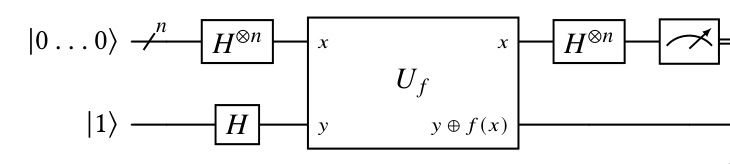

Run the circuit below, and measure the $n$ first qubits.  $f$ est constant if $|0...0\rangle$ was measured, and balanced otherwise. This requires one single run of the algorithm!

The goal of this exercice is to implement this algorithm. For this, we are going to use a function $f$ of the form
$$
f(x_1,...x_n) = x_{k_1}\oplus...\oplus x_{k_m}
$$

1. When is such an $f$ constant ? balanced ?

2. How would you implement $U_f$ ?

3. Test the algorithm for a few (valid) functions $f$ on $5$ wires. 
